In [65]:
!pip install mock



In [120]:
import pandas as pd
import numpy as np
import os
import enum
import itertools
import functools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from keras import backend as K
import torch
import torch.nn as nn
import mock
import torch.optim as optim
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import trange, tqdm



from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
# from visuals import plot_examples, plot_3d_example
import matplotlib.gridspec as gridspec
import plotly.graph_objs as go
import plotly.offline as py
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, Dropout, Flatten, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten, Dense
import torchnet as tnt
from functools import partial
import torch.nn.functional as nnf


py.init_notebook_mode(connected=True)
%matplotlib inline

In [121]:
# here is where you save your images
datafolder=r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\STK'

# list of convenience
bands = ['VV', 'VH', 'VV/VH']
print('bands:',bands)
#%% Loading the images
#[C11, C22_full, C12] = np.load(path_save + 'filename.npy')
img=np.load(datafolder + '\TrainingData_Vembanadlake_64.npy')
print('Reading pre-stored stack of patches...',images_orig.shape)    

GT=np.load(datafolder + '\GTData_Vembanadlake_64.npy')
print('Reading pre-stored stack of GT patches...',GT.shape)    


category_names = [
 'clean water',
 'infested water']


# load all data
N_images = 16  # per category
nb_classes = 2
patch_size = 64  # width and height in pixel
channels = 3
nb_images = N_images * nb_classes

bands: ['VV', 'VH', 'VV/VH']
Reading pre-stored stack of patches... (32, 64, 64, 3)
Reading pre-stored stack of GT patches... (32, 64, 64)


In [122]:
shuffled_indices = np.arange(nb_images)
np.random.seed(0)
np.random.shuffle(shuffled_indices)

training_indices = shuffled_indices[:int(0.8*nb_images)]               # 70% for training
#val_indices = shuffled_indices[int(0.7*nb_images):int(0.8*nb_images)]  # 30% for val
test_indices = shuffled_indices[int(0.8*nb_images):]                   # 20% for test

train_obs = images_orig[training_indices]
#val_images = images_orig[val_indices]
test_obs = images_orig[test_indices]

train_gt=GT[training_indices]
test_gt=GT[test_indices]

n_train = train_obs.shape[0]
n_test = test_obs.shape[0]
class_names = ["clean water", "infested water"]



print("%d tiles for training, %d tiles for testing" % (n_train, n_test))

25 tiles for training, 7 tiles for testing


In [123]:
#[4] data loader

def augment(obs, gt):
  """augmentation function
  Leave untouched for now until question XX
  """
  return obs, gt#does nothing, leaves like that for now
  #random gaussian noise
  sigma, clip= 0.01, 0.02 # https://github.com/charlesq34/pointnet/blob/master/provider.py#L74
  obs = obs + np.clip(sigma * np.random.randn(*obs.shape), -1*clip, clip).astype(np.float32)
  #random rotation 0 90 180 270 degree
  #n_turn =  np.random.randint(4)   #removed because detrmental, see Q14
  #obs = np.rot90(obs, k=n_turn, axes=(1,2)).copy()
  #gt = np.rot90(gt, k=n_turn, axes=(0,1)).copy()
  return obs, gt


def tile_loader(tile_index, train = True):
  """
  load a tile and returns the obseravtion and associated ground truth
  INPUT:
  tile_index = int, index of the tile
  train = int, train = 1 iff in the train set
  OUTPUT
  obs, [256 x 256 x 4] float array containing the observation
  gt, [256 x 256] uint8 array, containing the pixels semantic labels  
  """
  if train:
    obs = train_obs[tile_index,:,:,:].transpose(2,0,1) #put channels first
    gt = train_gt[tile_index,:,:]
  else:
    obs = test_obs[tile_index,:,:,:].transpose(2,0,1)
    gt = test_gt[tile_index,:,:]
    
  if train: #augmentation - for training only
    obs, gt = augment(obs, gt)   
  
  obs = torch.from_numpy(obs)
  gt = torch.from_numpy(gt)
   
  return obs, gt.long()

#putting the dataset into the ListDataset wrapper
test_set  = tnt.dataset.ListDataset(list(range(n_test)),functools.partial(tile_loader, train=False))
train_set = tnt.dataset.ListDataset(list(range(n_train)),functools.partial(tile_loader, train=True))


In [124]:
def viewer(n_shown = 3, category = 'cig', train = True, model = None, use_mask = False):
  """ plot 'n_shown' random tiles train/test set with the following visuals:
  if 'c' in category : rgb color
  if 'i' in category : infrared
  if 'g' in category : ground truth
  if 'p' in category : prediction
  if 'e' in category : error
  Note that for 'p' or 'e' ou need to add a trained model as input
  
  """
  n_category = len(category) #number of types of image to show
  fig = plt.figure(figsize=(n_category * 5, n_shown * 5)) #adapted dimension
  
  subplot_index = 1 #keep track of current subplot
  
  #chose random tiles
  tile_indices = np.random.choice(n_train, n_shown) if train \
  else np.random.choice(n_test, n_shown)
  
  for tile_index in tile_indices:
    
    tile, gt = tile_loader(tile_index, train = train)
    
    if 'c' in category:
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='RGB')
      view_rgb(tile, ax = ax)
      subplot_index += 1
    if 'i' in category:  
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Infrared')
      view_rgb(tile, ax = ax)
      subplot_index += 1
    if 'g' in category:  
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Ground Truth')
      view_labels(gt, ax = ax)
      subplot_index += 1
    if 'p' in category:  
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Prediction')
      pred = model(tile[None,:,:,:].cuda()).cpu().argmax(1).squeeze()
      if use_mask:
        pred[gt==99] = 99
      view_labels(pred, ax = ax)
      subplot_index += 1  
    if 'e' in category: 
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Error')
      #pred = model(tile[None,:,:,:].cuda()).cpu().argmax(1).squeeze()
      pred = model(tile[None,:,:,:].cpu()).argmax(1).squeeze()

      view_error(pred, gt, ax = ax)
      subplot_index += 1
  plt.show()

In [125]:
train_obs[:3,:,].shape

(3, 64, 64, 3)

In [126]:
def view_rgb(tile, ax = None):
  """ show the rgb values of the tile in figure ax"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  tile_corrected = np.minimum(np.maximum(tile[:3,:,], 0), 1) #normalization
  ax.imshow(tile_corrected.transpose(0,2).
  transpose(0,1)) #put channels back as dim 3
  plt.axis('off')

In [127]:
def view_labels(label, ax = None, mask = None):
  """ show the ground truth with a colorcode corresponding to labels"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  if mask is not None:
    label[mask] = 99
  n_pixel = label.shape[1]
  colors = np.zeros((n_pixel,n_pixel,3))
  colors[np.where(label==99)] = [1  ,1  ,1  ] #not labelled
  colors[np.where(label==0)]  = [1  ,0.8,0.8] #building limit
  colors[np.where(label==1)]  = [0  ,0  ,1  ] #water
  colors[np.where(label==2)]  = [0.9,0.9,0  ] #fields
  colors[np.where(label==3)]  = [0.5,0.5,0.5] #road
  colors[np.where(label==4)]  = [0  ,.8  ,0  ] #vegetation
  colors[np.where(label==5)]  = [1,  0  ,0  ] #building
  ax.imshow(colors)
  plt.axis('off')

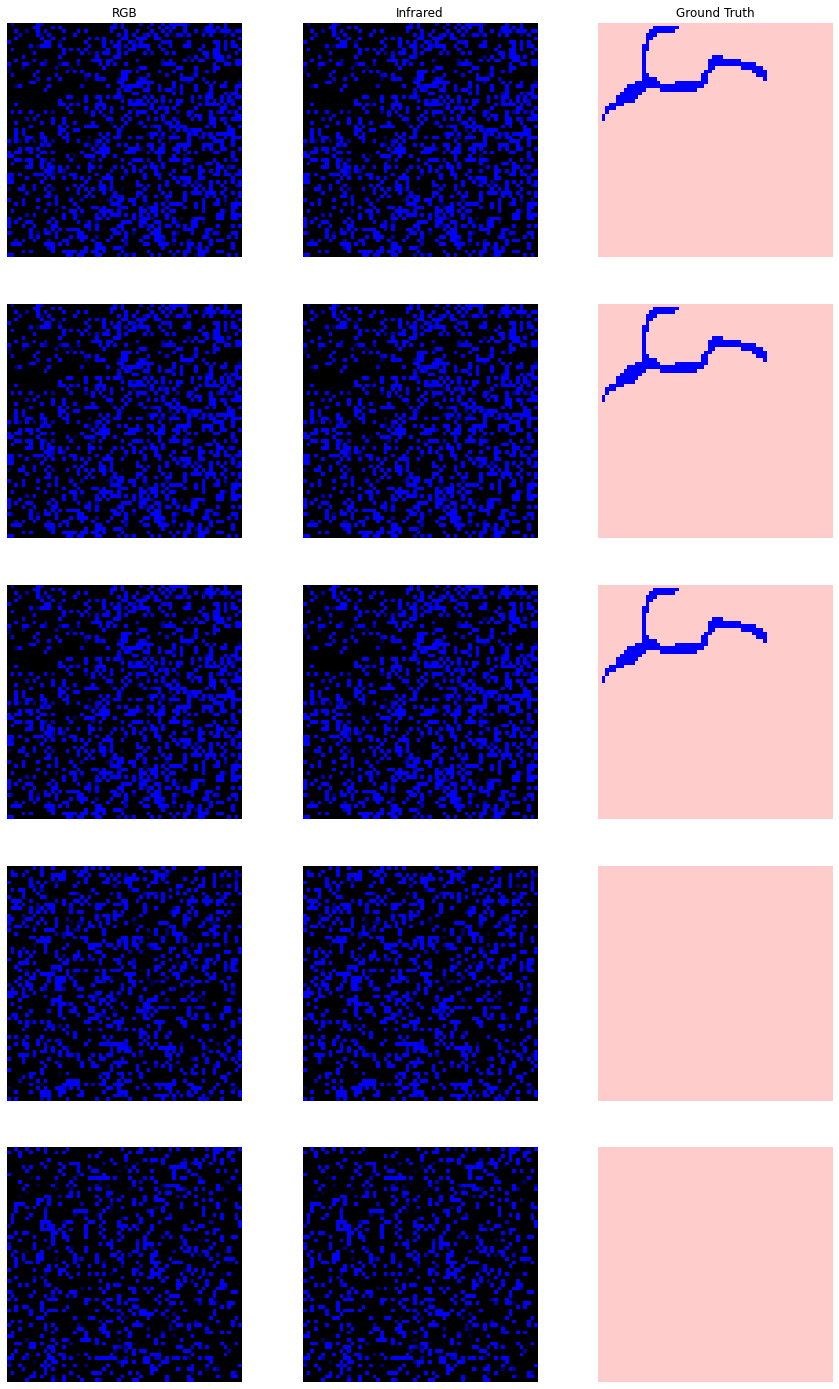

In [128]:
viewer(n_shown = 5, category = 'cig', train = True)

In [129]:
#[7]
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class))
    self.n_class = n_class
    self.class_names = class_names
  
  def clear(self):
    self.CM = np.zeros((self.n_class, self.n_class))
    
  def add_batch(self, gt, pred):
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))
    
  def overall_accuracy(self):#percentage of correct classification
    return 100*self.CM.trace() / self.CM.sum()

  def class_IoU(self, show = 1):
    ious = np.diag(self.CM)/ (self.CM.sum(0) + self.CM.sum(1) - np.diag(self.CM))
    if show:
      print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [135]:
#[9]
class SegNet(nn.Module):
  """
  SegNet network for semantic segmentation
  """
  
  def __init__(self, n_channels, conv_width,  n_class, cuda = 1):
    """
    initialization function
    n_channels, int, number of input channel
    conv_width, int list, depth of the convs
    n_class = int,  the number of classes
    """
    super(SegNet, self).__init__() #necessary for all classes extending the module class
    self.is_cuda = cuda
    
    assert((conv_width[3] == conv_width[5]) \
     and (conv_width[1] == conv_width[7]))
    
    self.maxpool=nn.MaxPool2d(2,2,return_indices=True) #maxpooling layer
    self.unpool=nn.MaxUnpool2d(2,2) #unpooling layer
    #encoder
    self.c0 = nn.Sequential(nn.Conv2d(n_channels,conv_width[0],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[0]),nn.ReLU(True))
    self.c1 = nn.Sequential(nn.Conv2d(conv_width[0],conv_width[1],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[1]),nn.ReLU(True))
    self.c2 = nn.Sequential(nn.Conv2d(conv_width[1],conv_width[2],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[2]),nn.ReLU(True))
    self.c3 = nn.Sequential(nn.Conv2d(conv_width[2],conv_width[3],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[3]),nn.ReLU(True))
    self.c4 = nn.Sequential(nn.Conv2d(conv_width[3],conv_width[4],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[4]),nn.ReLU(True))
    self.c5 = nn.Sequential(nn.Conv2d(conv_width[4],conv_width[5],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[5]),nn.ReLU(True))
    #decoder
    self.c6=nn.Sequential(nn.Conv2d(conv_width[5]+conv_width[3],conv_width[6],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[6]),nn.ReLU(True))
    self.c7=nn.Sequential(nn.Conv2d(conv_width[6],conv_width[7],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[7]),nn.ReLU(True))       
    self.c8=nn.Sequential(nn.Conv2d(conv_width[1] + conv_width[7],conv_width[8],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[8]),nn.ReLU(True))
    self.c9=nn.Sequential(nn.Conv2d(conv_width[8],conv_width[9],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(conv_width[9]),nn.ReLU(True))
    #final classifying layer
    self.c10=nn.Conv2d(conv_width[9],n_class,1,padding=0, padding_mode='reflect')

    #weight initialization

    self.c0[0].apply(self.init_weights)
    self.c0[0].apply(self.init_weights)
    self.c2[0].apply(self.init_weights)
    self.c3[0].apply(self.init_weights)
    self.c4[0].apply(self.init_weights)
    self.c5[0].apply(self.init_weights)
    self.c6[0].apply(self.init_weights)
    self.c7[0].apply(self.init_weights)
    self.c8[0].apply(self.init_weights)
    self.c9[0].apply(self.init_weights)
    self.c10.apply(self.init_weights)
    
    if cuda: #put the model on the GPU memory
      self.cuda()
    
  def init_weights(self,layer): #gaussian init for the conv layers
    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
  def forward(self,input):
    """
    the function called to run inference
    """  
    if self.is_cuda: #put data on GPU
        input = input.cuda()
    #encoder
    #level a
    x1 = self.c1(self.c0(input))
    x2, indices_a_b =self.maxpool(x1)
    #level b
    x3=self.c3(self.c2(x2))
    x4, indices_b_c =self.maxpool(x3)
    #level c
    x5 = self.c5(self.c4(x4))
    #decoder
    #level b       
    x6 = self.unpool(x5, indices_b_c)
    x7 = self.c7(self.c6(torch.cat((x6,x3),1)))
    #level a       
    x8 = self.unpool(x7, indices_a_b)
    x9 = self.c9(self.c8(torch.cat((x8,x1),1)))
    #output         
    out = self.c10(x9)
    return out

In [134]:
#[10]
#==================TEST===============================
#we consider the first point cloud from the training set
tile, gt = tile_loader(0)
segnet = SegNet(3,[16,16,32,32,64,32,32,16,32,16],6)
print(segnet)
print('Total number of parameters: {}'.format(sum([p.numel() for p in segnet.parameters()])))
pred = segnet(tile[None,:,:,:]) #the None indicate a batch size of 1
print(pred.shape)
assert(pred.shape == torch.Size([1,6,64,64]))

AssertionError: Torch not compiled with CUDA enabled

In [118]:
#[10]
#==================TEST===============================
#we consider the first point cloud from the training set
tile, gt = tile_loader(0)
segnet = SegNet(4,[16,16,32,32,64,32,32,16,32,16],6)
print(segnet)
print('Total number of parameters: {}'.format(sum([p.numel() for p in segnet.parameters()])))
pred = segnet(tile[None,:,:,:]) #the None indicate a batch size of 1
print(pred.shape)
assert(pred.shape == torch.Size([1,6,64,64]))

SegNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (c0): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (c1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (c3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)

RuntimeError: Given groups=1, weight of size [16, 4, 3, 3], expected input[1, 3, 66, 66] to have 4 channels, but got 3 channels instead

Total number of parameters: 91254


  0%|                                                                                                         …


clean water : 4.90%  |  infested water : 3.75%
Epoch   0 -> Train Overall Accuracy: 5.00% Train mIoU : 1.44% Train Loss: 2.7093


  0%|                                                                                                         …


clean water : 7.83%  |  infested water : 36.02%
Epoch   1 -> Train Overall Accuracy: 9.81% Train mIoU : 7.31% Train Loss: 2.3102


  0%|                                                                                                         …


clean water : 14.81%  |  infested water : 27.99%
Epoch   2 -> Train Overall Accuracy: 15.92% Train mIoU : 7.13% Train Loss: 2.0176


  0%|                                                                                                         …


clean water : 23.07%  |  infested water : 26.03%
Epoch   3 -> Train Overall Accuracy: 23.54% Train mIoU : 8.18% Train Loss: 1.7811


  0%|                                                                                                         …


clean water : 27.09%  |  infested water : 36.45%
Epoch   4 -> Train Overall Accuracy: 28.60% Train mIoU : 10.59% Train Loss: 1.6040


  0%|                                                                                                         …


clean water : 40.97%  |  infested water : 43.61%
Epoch   5 -> Train Overall Accuracy: 42.15% Train mIoU : 14.10% Train Loss: 1.4627


  0%|                                                                                                         …


clean water : 0.04%  |  infested water : 5.25%
Test Overall Accuracy: 3.58% Test mIoU : 0.88%  Test Loss: 134.1993


AssertionError: Torch not compiled with CUDA enabled

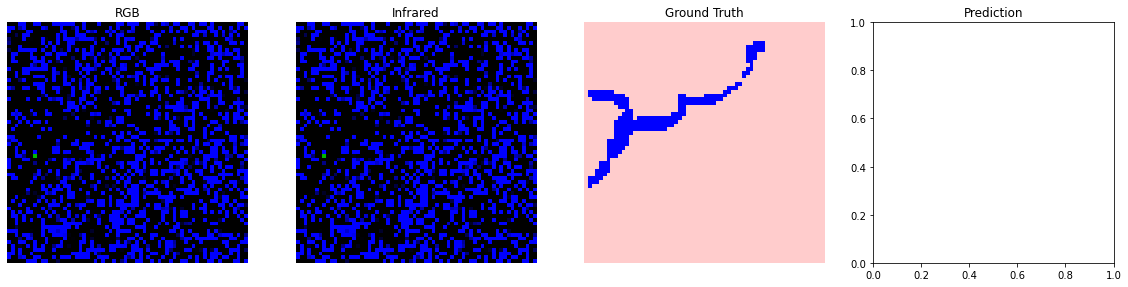

In [132]:
#[12]
args = mock.Mock() #stores the parameters
args.n_epoch = 50
args.n_epoch_test = int(5) #periodicity of evaluation on test set
args.batch_size = 16
args.n_class = 6
args.n_channel = 3
args.conv_width = [16,16,32,32,64,32,32,16,32,16]
args.cuda = 1
args.lr = 5e-3

trained_model = train_full(args)

In [73]:
tile, gt = tile_loader(6, train = train, cuda=0)
pred = trained_model(tile[None,:,:,:].cuda()).cpu().squeeze()
np.save('pred.npy', np.moveaxis(pred.detach().numpy(), 0, -1))
files.download( "pred.npy" )
view_rgb(tile, ax = None)
view_labels(pred.argmax(0))

TypeError: tile_loader() got an unexpected keyword argument 'cuda'

Total number of parameters: 91254


  0%|                                                                                                         …


clean water : 0.44%  |  infested water : 7.42%
Epoch   0 -> Train Overall Accuracy: 1.94% Train mIoU : 1.31% Train Loss: 5.0535


  0%|                                                                                                         …


clean water : 0.44%  |  infested water : 19.30%
Epoch   1 -> Train Overall Accuracy: 3.48% Train mIoU : 3.29% Train Loss: 4.0691


  0%|                                                                                                         …


clean water : 1.34%  |  infested water : 20.10%
Epoch   2 -> Train Overall Accuracy: 3.77% Train mIoU : 3.57% Train Loss: 3.0860


  0%|                                                                                                         …


clean water : 8.62%  |  infested water : 19.75%
Epoch   3 -> Train Overall Accuracy: 10.38% Train mIoU : 4.73% Train Loss: 2.5628


  0%|                                                                                                         …


clean water : 18.01%  |  infested water : 27.56%
Epoch   4 -> Train Overall Accuracy: 19.54% Train mIoU : 7.59% Train Loss: 2.2734


  0%|                                                                                                         …


clean water : 22.82%  |  infested water : 41.96%
Epoch   5 -> Train Overall Accuracy: 25.06% Train mIoU : 10.80% Train Loss: 1.9931


  0%|                                                                                                         …


clean water : 0.00%  |  infested water : 5.46%
Test Overall Accuracy: 4.98% Test mIoU : 1.82%  Test Loss: 333.6662


C:\Users\vaak\Anaconda3\envs\snappy\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



AssertionError: Torch not compiled with CUDA enabled

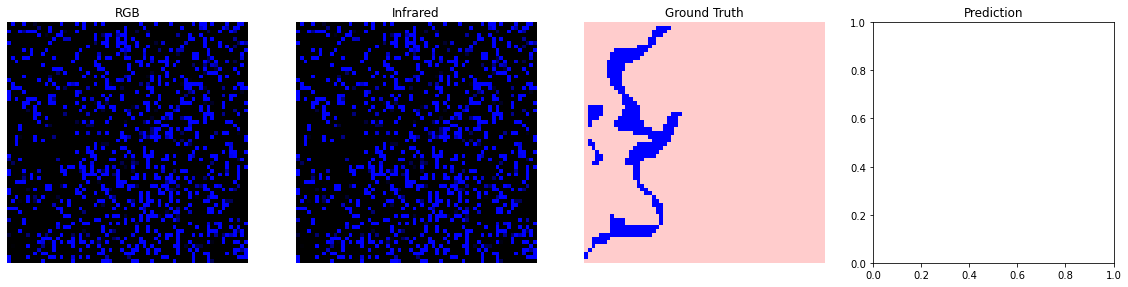

In [82]:
trained_model = train_full(args)

pred = trained_model(tile[None,:,:,:].cuda()).cpu().squeeze()

In [74]:
viewer(n_shown=5, category = 'cigpe', model = trained_model, train = False, use_mask = True)

NameError: name 'trained_model' is not defined